In [38]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [54]:
class BreastScanDataset(Dataset):
    def __init__(self, data, root_dir, transform=None):
        self.data = data
        self.root_dir = root_dir
        self.transform = transform
        self.label_map = {i: label for i, label in enumerate(data.columns[3:])}  # Create a mapping from class index to label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = self.root_dir+self.data.iloc[idx, 2][1:]
        image = Image.open(img_path).convert('RGB')  # Convert image to 'RGB'
        label_vector = self.data.iloc[idx, 3:]
        label_index = torch.argmax(torch.tensor(label_vector))  # Convert one-hot vector to class index

        if self.transform:
            image = self.transform(image)
            
        return image, label_index

    def get_label(self, index):
        return self.label_map[index]

In [55]:
dataset_path ='/data/md311/Breast_Cancer_Detection_DBT/dataset/' 
df = pd.read_csv(dataset_path+'data_csv/train-v2_table_list_slice.csv')
df.drop(df.tail(16000).index, axis=0, inplace=True)
df

,StudyUID,view,img_path,Normal,Actionable,Benign,Cancer
0,DBT-S00163,rmlo,./images/train-v2/DBT-S00163_rmlo_16.png,0,0,1,0
1,DBT-S04378,lcc,./images/train-v2/DBT-S04378_lcc_31.png,0,1,0,0
2,DBT-S04378,lmlo,./images/train-v2/DBT-S04378_lmlo_33.png,0,1,0,0
3,DBT-S04378,rcc,./images/train-v2/DBT-S04378_rcc_29.png,0,1,0,0
4,DBT-S04378,rmlo,./images/train-v2/DBT-S04378_rmlo_31.png,0,1,0,0
...,...,...,...,...,...,...,...
892,DBT-S02614,rmlo,./images/train-v2/DBT-S02614_rmlo_29.png,0,1,0,0
893,DBT-S01815,lcc,./images/train-v2/DBT-S01815_lcc_29.png,1,0,0,0
894,DBT-S01815,lmlo,./images/train-v2/DBT-S01815_lmlo_31.png,1,0,0,0
895,DBT-S01815,rcc,./images/train-v2/DBT-S01815_rcc_26.png,1,0,0,0


In [56]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit ResNet input size
    transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet mean and std
])

# Create a new column indicating whether each study includes at least one image where 'Cancer' is 1
df['StudyHasCancer'] = df.groupby('StudyUID')['Cancer'].transform('max')

# Get the unique studies and their cancer status
unique_studies = df[['StudyUID', 'StudyHasCancer']].drop_duplicates()

# Split the studies using stratified sampling based on the 'StudyHasCancer' column
train_studies, test_studies = train_test_split(unique_studies, test_size=0.2, stratify=unique_studies['StudyHasCancer'], random_state=42)

# Get the training and test data
train_data = df[df['StudyUID'].isin(train_studies['StudyUID'])]
test_data = df[df['StudyUID'].isin(test_studies['StudyUID'])]

# Create datasets
train_dataset = BreastScanDataset(train_data, dataset_path, transform)
test_dataset = BreastScanDataset(test_data, dataset_path, transform)

unique_labels = [train_dataset.get_label(i) for i in np.sort(np.unique(y_true))]

# Create data loaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [57]:
train_studies["StudyHasCancer"].value_counts()

0    180
1     15
Name: StudyHasCancer, dtype: int64

In [61]:
# Define the function to load the pre-trained model and modify the final layer
def load_model(num_classes):
    # Load the pretrained model
    model = models.resnet50(pretrained=True)
    
    # Freeze model parameters
    for param in model.parameters():
        param.requires_grad = False
    
    # Get the input of the fc layer
    num_ftrs = model.fc.in_features
    
    # Re-define the fc layer / classifier
    model.fc = nn.Linear(num_ftrs, num_classes)
    
    return model

# Define the function to get the loss function and the optimizer
def get_loss_optimizer(model, learning_rate):
    # Define the loss function
    criterion = nn.CrossEntropyLoss()
    
    # Define the optimizer
    optimizer = torch.optim.Adam(model.fc.parameters(), lr=learning_rate)
    
    return criterion, optimizer

def train_model_cv(model, criterion, optimizer, dataset, train_loader, device, num_epochs, n_splits):
    model.to(device)
    
    # Initialize the KFold class
    kfold = KFold(n_splits=n_splits, shuffle=True)

    # Initialize lists to store the loss values
    train_losses = []
    val_losses = []
    epochs = []

    # Start the k-fold cross-validation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        # Print
        print(f'FOLD {fold}')
        print('--------------------------------')

        # Define the data loaders for training and validation
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        train_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=train_subsampler)
        val_loader = torch.utils.data.DataLoader(dataset, batch_size=32, sampler=val_subsampler)

        # Train the model
        model.train()
        for epoch in range(num_epochs):
            running_loss = 0.0
            for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / len(train_loader.dataset)
            print(f'Train Loss: {epoch_loss:.4f}')
            train_losses.append(epoch_loss)
            epochs.append(epoch)

            # Validation
            model.eval()
            running_loss = 0.0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validation"):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    running_loss += loss.item() * inputs.size(0)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            epoch_loss = running_loss / len(val_loader.dataset)
            print(f'Validation Loss: {epoch_loss:.4f}')
            val_losses.append(epoch_loss)

    # Create a DataFrame from the lists
    loss_df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': train_losses,
        'Validation Loss': val_losses
    })

    # Plot the training and validation loss
    sns.lineplot(data=loss_df, x='Epoch', y='Training Loss')
    sns.lineplot(data=loss_df, x='Epoch', y='Validation Loss')
    plt.show()


# Cell 5: Define the function to evaluate the model
def evaluate_model(model, test_loader, device, unique_labels):
    print("Evaluating Model")
    # Evaluate the model
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []
    all_probs = []
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]  # Get the predicted probabilities for the positive class
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    print("All Labels:\n",all_labels)
    print("All Preds:\n",all_preds)
    print("All Probs:\n",all_probs)

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    roc_auc = 0#roc_auc_score(all_labels, all_probs, average='macro', multi_class='ovo')

    print(f"Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1: {f1:.2f}\nAUC: {roc_auc:.2f}")

    # Plot confusion matrix
    plot_confusion_matrix(all_labels,all_preds,"Hey", unique_labels)
    # cm = confusion_matrix(all_labels, all_preds)
    # sns.heatmap(cm, annot=True)
    # plt.show()

def plot_confusion_matrix(y_true, y_pred, task, unique_labels):
    
     
    plt.figure(figsize=(9,7),dpi=150)
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_pred), index=unique_labels, columns=unique_labels)
    print('\nConfusion Matrix:\n')
    print(conf_mat)
    sns.heatmap(conf_mat, annot=True, fmt='g', cmap='Blues', linewidth=.5, square=True)
    plt.ylabel('True Labels')
    plt.xlabel('Predicted Labels')
    plt.title("Confusion Matrix")
    plt.show()
    # plt.savefig('fig/confusion_matrix_'+task+'.png')

/home/md311/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/md311/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FOLD 0
--------------------------------


Epoch 1/1, Training: 100%|███████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.32s/it]


Train Loss: 0.5432


Epoch 1/1, Validation: 100%|█████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.05s/it]


Validation Loss: 0.5390
FOLD 1
--------------------------------


Epoch 1/1, Training: 100%|███████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.05s/it]


Train Loss: 0.5025


Epoch 1/1, Validation: 100%|█████████████████████████████████████████████████| 11/11 [00:36<00:00,  3.32s/it]

Validation Loss: 0.4877


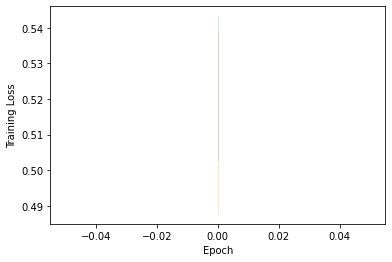

In [59]:
num_classes = 4  
learning_rate = 0.001 
num_epochs = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # Use GPU if available, otherwise use CPU
n_splits = 2

model = load_model(num_classes)
criterion, optimizer = get_loss_optimizer(model, learning_rate)
train_model_cv(model, criterion, optimizer, train_dataset, train_loader, device, num_epochs, n_splits) 

Evaluating Model
All Labels:
 [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0]
All Preds:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


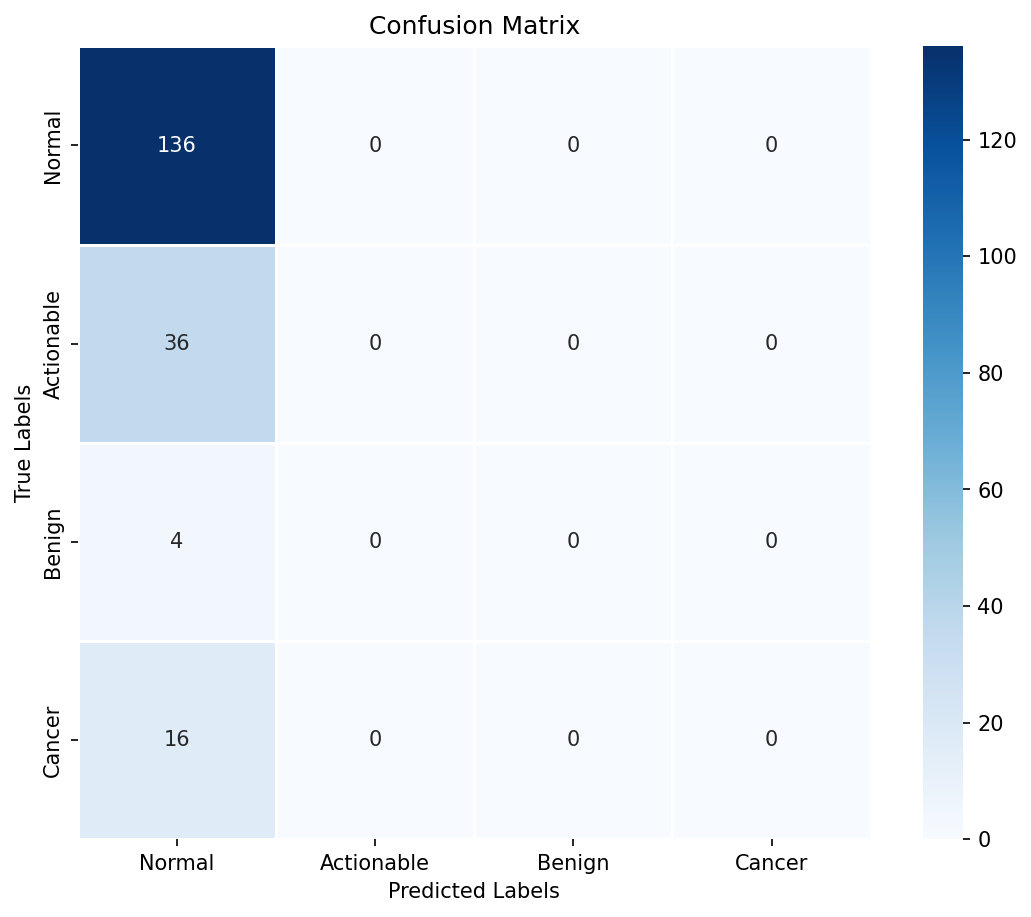

In [62]:
evaluate_model(model, test_loader, device)  # Replace test_loader with your actual test data loader